<font size="8"> **Calculating mean environmental conditions from observations during crabeater weaning period** </font>  
Here, we will calculate the mean environmental conditions crabeaters experienced in East Antarctica during the weaning period (for the period for which we have crabeater data) from observations. We will use this information to estimate the distribution of crabeater seals during their weaning period.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading other relevant libraries

In [2]:
from dask.distributed import Client
from glob import glob
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt

# Paralellising work 

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44509/status,
Dashboard: /proxy/44509/status,Workers: 7
Total threads: 14,Total memory: 56.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32849,Workers: 7
Dashboard: /proxy/44509/status,Total threads: 14
Started: Just now,Total memory: 56.00 GiB
Comm: tcp://127.0.0.1:39423,Total threads: 2
Dashboard: /proxy/42683/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:40223,


# Getting date range from crabeater seal observations
We will calculate the mean conditions of every over the period for which we have crabeater observations. The weaning period happens between November and December.

In [4]:
#Loading dataset as pandas data frame
crabeaters = pd.read_csv('../Biological_Data/unique_crabeater_obs_grid.csv')

#Selecting weaning period
crabeaters = crabeaters[crabeaters.life_stage == 'weaning']

#Print minimum and maximum years
print(crabeaters.year.min(), crabeaters.year.max())

1981 2022


# Loading Indian sectors mask
Since our area of interest includes the East and Central Indian sectors, we will apply a mask to the data prior to calculating the mean for each variable.

In [5]:
#All variables except velocity
measo = xr.open_dataarray('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
#Renaming dimensions to match model data
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))

#Checking result
measo

<xarray.DataArray 'mask' (yt_ocean: 713, xt_ocean: 3600)>
[2566800 values with dtype=float64]
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0

## Loading keys to identify the East and Central Indian sectors
The MEASO mask includes all sectors within the Southern Ocean. Here we print the keys on the screen to identify the numeric ID given to all zones (Antarctic, Subantarctic and Northern) included within the Central and East Indian sectors.

In [6]:
#Loading keys
measo_key = pd.read_csv('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_keys.csv')
#Identifying Indian sectors
measo_key[measo_key.LongName.str.contains('Indian')]

,name,LongName,ID
9,CIA,Central Indian Antarctic,13
10,CIS,Central Indian Subantarctic,14
11,CIN,Central Indian Northern,15
12,EIA,East Indian Antarctic,17
13,EIS,East Indian Subantarctic,18
14,EIN,East Indian Northern,19


## Creating mask for the Indian sectors only
We will use the `ID` column to select the Indian sectors only. Our maximum latitudinal range is $55^{\circ}S$, as we do not expect crabeaters to occupy open water areas offshore during the weaning period.

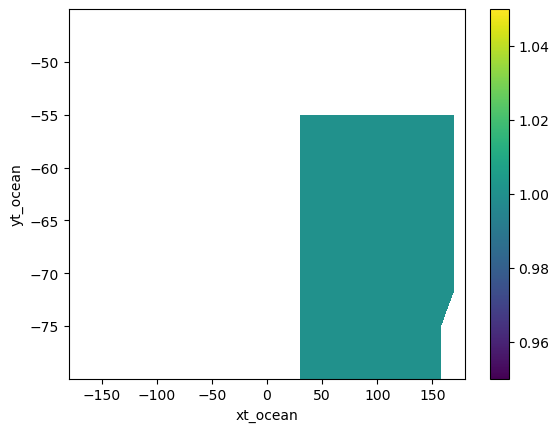

In [7]:
#Subsetting both masks
measo_ind = xr.where((measo >= 13) & (measo <= 19) & (measo.yt_ocean <= -55), 1, np.nan)
#Checking results
measo_ind.plot()

In [8]:
#Full path to static variables
base_dir_static = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'

#List of static variables
varDict = {'bottom_slope_deg': 'bathy_slope_GEBCO_2D.nc',
           'dist_shelf_km': 'distance_shelf.nc',
           'dist_coast_km': 'distance_coastline.nc',
           'depth_m': 'bathy_GEBCO_2D.nc'}

## Extracting data for each observation and adding it to a new column in crabeater data

In [9]:
#Looping through dictionary keys
for i, var in enumerate(varDict):
    #Creating full path to file of interest
    file_path = os.path.join(base_dir_static, varDict[var])
    #Load as raster
    ras = xr.open_dataarray(file_path)
    #Apply mask
    ras = ras.where(measo_ind == 1, drop = True)
    #Convert to data frame
    ras = ras.to_series().dropna().reset_index()
    #Round coordinate values
    ras = ras.round({'yt_ocean': 3, 'xt_ocean': 3})
    #Renaming masked data before merging to observations
    ras = ras.rename(columns = {ras.columns[-1]: var})
    #Creating data frame with data
    if i == 0:
        static_vars = ras
    else:
        static_vars = static_vars.merge(ras, on = ['yt_ocean', 'xt_ocean'], how = 'left')
    
#Checking results
static_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.816666
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.966660
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.299957
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.933319
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.933319
...,...,...,...,...,...,...
365117,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.154785
365118,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.309570
365119,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.023926
365120,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.833252


# Saving results

In [10]:
static_vars.to_csv('../Environmental_Data/All_values_static_vars.csv', index = False)

# Loading environmental data from observations

In [11]:
#Creating dictionary with useful information
varDict = {'var_original': 'dist_ice',
           'var_short_name': 'dist_ice_edge_km',
           'obs_base': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIceObs/Distance_Edge/north_south/*.nc',
           #Output folder
           'base_out': '../Environmental_Data/Env_obs'}
varDict

{'var_original': 'dist_ice',
 'var_short_name': 'dist_ice_edge_km',
 'obs_base': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIceObs/Distance_Edge/north_south/*.nc',
 'base_out': '../Environmental_Data/Env_obs'}

## Loading data 

In [21]:
#Getting list of all obs in folder
files_var = sorted(glob(varDict['obs_base']))
var = varDict['var_original']

#Loading all data into single dataset and selecting time of interest
var_df = xr.open_mfdataset(files_var)[var].sel(time = slice('1981-11', '2013-12')).chunk((1, 135, 180))
var_df.name = varDict['var_short_name']
if 'xt_ocean' not in var_df.coords:
    var_df = var_df.rename({'lon': 'xt_ocean', 'lat': 'yt_ocean'})

#Checking results
var_df

<xarray.DataArray 'dist_ice_edge_km' (time: 386, yt_ocean: 740, xt_ocean: 3600)>
dask.array<rechunk-merge, shape=(386, 740, 3600), dtype=float64, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time      (time) datetime64[ns] 1981-11-15 1981-12-15 ... 2013-12-15

# Calculating mean over time for weaning period
We will include data from 1981 to 2013. The weaning period includes the months of November and December.

In [22]:
#Identifying timesteps to be included in calculations
mean_var = [da for m, da in var_df.groupby('time.month') if m in [11, 12]]
#Concatenating into single data array and calculate monthly mean over entire time period and apply mask
mean_var = xr.concat(mean_var, dim = 'time').groupby('time.month').mean('time').where(measo_ind == 1, drop = True)
    
#Checking results
mean_var

<xarray.DataArray 'dist_ice_edge_km' (month: 2, yt_ocean: 557, xt_ocean: 1400)>
dask.array<where, shape=(2, 557, 1400), dtype=float64, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0
  * month     (month) int64 11 12

## Transform into data frame

In [23]:
#Converting to pandas data frame
var_pd = mean_var.to_series().dropna().reset_index()
#Round coordinate values
var_pd = var_pd.round({'yt_ocean': 3, 'xt_ocean': 3})
#Checking results
var_pd.head()

,month,yt_ocean,xt_ocean,dist_ice_edge_km
0,11,-71.267,169.55,-846.953408
1,11,-71.267,169.65,-845.760032
2,11,-71.267,169.75,-844.569962
3,11,-71.267,169.85,-843.339893
4,11,-71.267,169.95,-842.127949


## Adding mean calculations for dynamic environmental variables to data frame with static environmental data

In [12]:
#Loading file
env_vars = pd.read_csv('../Environmental_Data/All_values_static_vars.csv')
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.81667
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.96666
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.29996
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.93332
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.93332
...,...,...,...,...,...,...
365117,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.15480
365118,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.30960
365119,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.02400
365120,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.83330


In [13]:
#Getting number of times month has to be repeated
rows_month = env_vars.shape[0]

#Bind static variables by row
env_vars = pd.concat([env_vars, env_vars], axis = 0)

#Add a month column to bind data frame
env_vars['month'] = [11]*rows_month + [12]*rows_month

#Check results
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m,month
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.81667,11
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.96666,11
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.29996,11
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.93332,11
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.93332,11
...,...,...,...,...,...,...,...
365117,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.15480,12
365118,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.30960,12
365119,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.02400,12
365120,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.83330,12


## Merging all variables together

In [26]:
#Getting column names for merging
cols = var_pd.drop(columns = varDict['var_short_name']).columns.tolist()
#Merging columns
env_vars = env_vars.merge(var_pd, on = cols, how = 'left')

#Checking results
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m,month,SIC,SST_degC,lt_pack_ice,dist_ice_edge_km
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.81667,11,NaN,NaN,0.0,NaN
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.96666,11,NaN,NaN,0.0,NaN
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.29996,11,NaN,NaN,0.0,NaN
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.93332,11,NaN,NaN,0.0,NaN
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.93332,11,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
730239,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.15480,12,0.0,7.449074,0.0,976.934800
730240,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.30960,12,0.0,7.415208,0.0,978.028242
730241,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.02400,12,0.0,7.379899,0.0,979.101075
730242,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.83330,12,0.0,7.344506,0.0,980.139645


## Saving results

In [27]:
#Ensure output folder exists
os.makedirs(varDict['base_out'], exist_ok = True)

#Create file path where data will be saved
file_out = os.path.join(varDict['base_out'], 'All_values_month_Obs_env_vars.csv')

env_vars.to_csv(file_out, index = False)